# Predictive maintenance using forecasting timeseries data 

## Loading and cleaning up the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_analysis.csv')
df.drop(df.columns[[0]], axis = 1, inplace = True)
df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df = df.set_index('timestamp')
# df.dropna(inplace=True)
df = df.fillna(df.mean())

In [3]:
df.head()

,sen_0,sen_1,sen_2,sen_3,sen_4,sen_5,sen_6,machine_op
timestamp,,,,,,,,
2019-11-23 01:00:00,2.542807,48.570699,54.882651,47.764918,654.294375,78.860586,32.417532,NORMAL
2019-11-23 01:01:00,2.542807,48.570699,54.882651,47.764918,654.294375,78.860586,32.417532,NORMAL
2019-11-23 01:02:00,2.521499,48.839296,54.882651,47.854454,658.950011,75.855324,32.478299,NORMAL
2019-11-23 01:03:00,2.537733,48.570699,54.837888,47.854451,647.848125,79.406434,32.478297,NORMAL
2019-11-23 01:04:00,2.522514,48.615462,54.882651,47.854451,656.443091,78.993864,32.478297,NORMAL


In [4]:
df.machine_op = pd.Categorical(df.machine_op)
#df['mop_id'] = df.machine_op.cat.codes
df.isna().sum()

sen_0         0
sen_1         0
sen_2         0
sen_3         0
sen_4         0
sen_5         0
sen_6         0
machine_op    0
dtype: int64

In [5]:
df['machine_op'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_op, dtype: int64

## Diving Deeper into Analysis

Plotting when the machine becomes broken as per each sensor

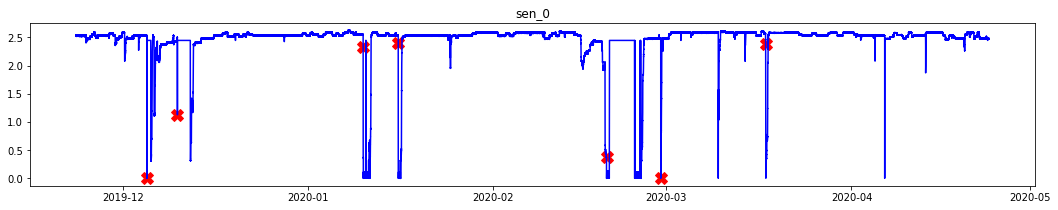

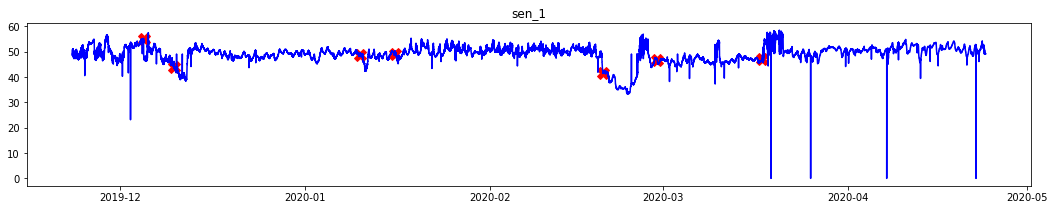

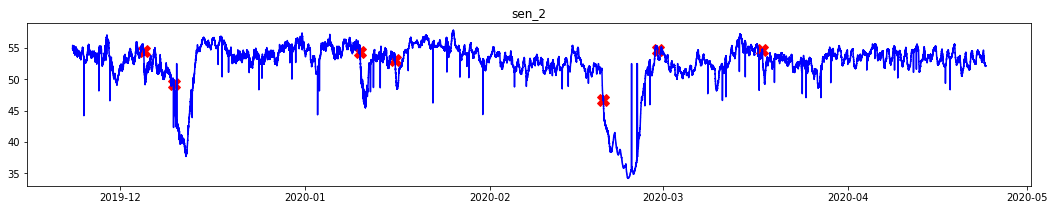

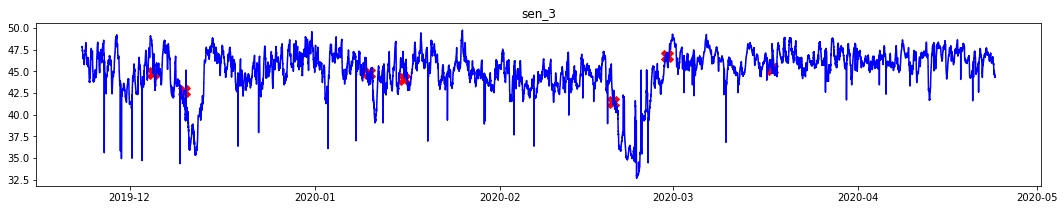

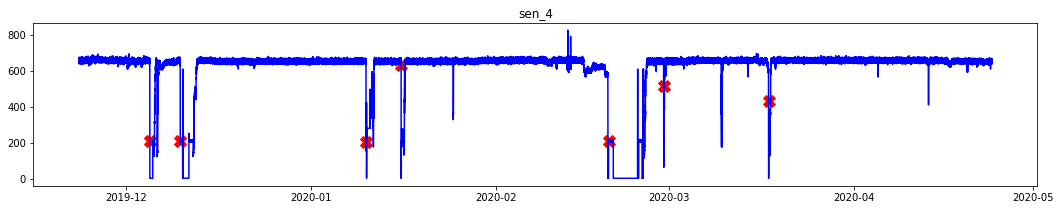

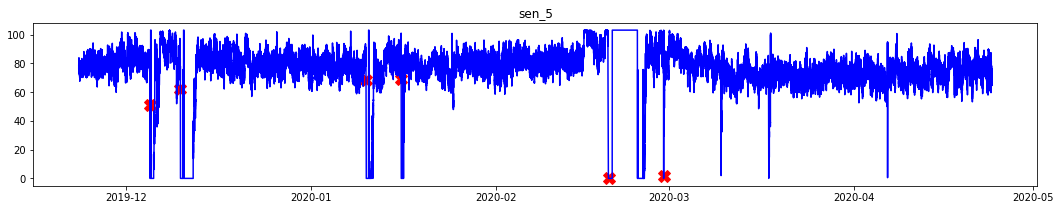

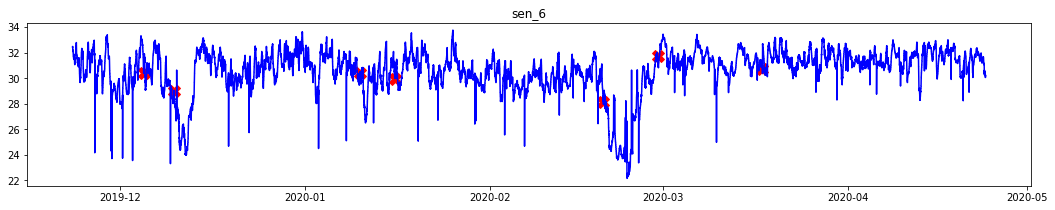

In [6]:
broken = df[df['machine_op']=='BROKEN']
df2 = df.drop(['machine_op'], axis=1)
names=df2.columns
for name in names:
  plt.figure(figsize=(18,3))
  plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
  plt.plot(df[name], color='blue')
  plt.title(name)
  plt.show()

From the plots, sensors 4 and 5 are dropping in values whenever the machine becomes broken.

### Testing if the data is stationary

Considering the rolling mean and std of the dataset averaged for each day.


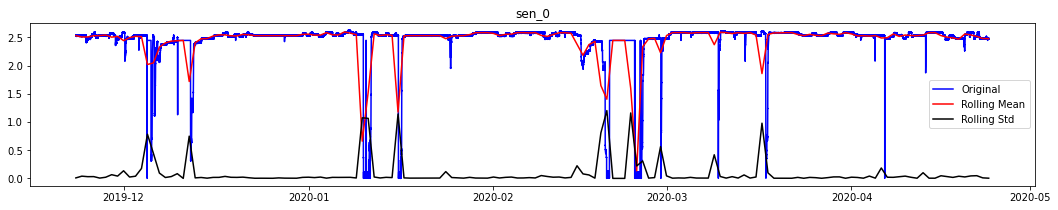

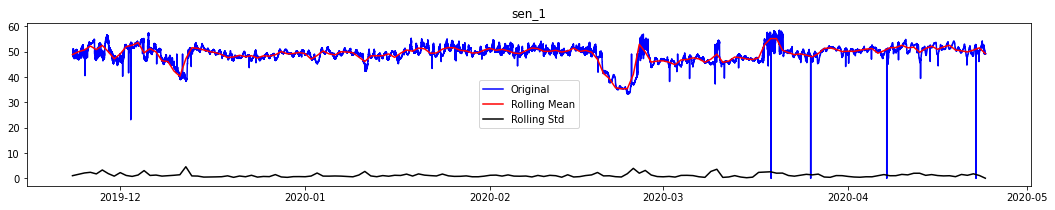

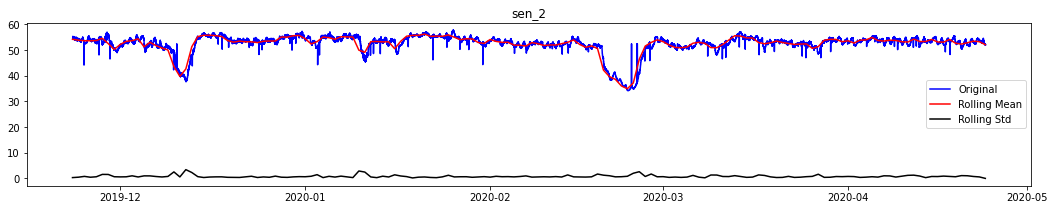

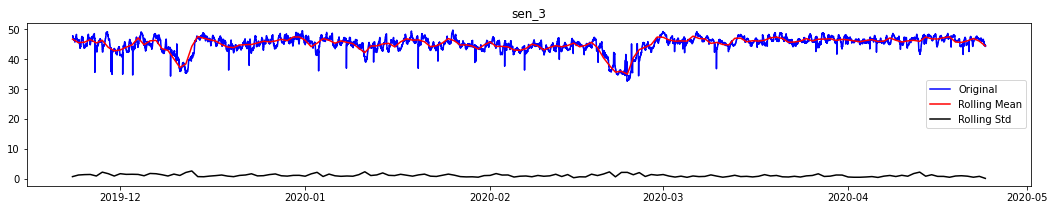

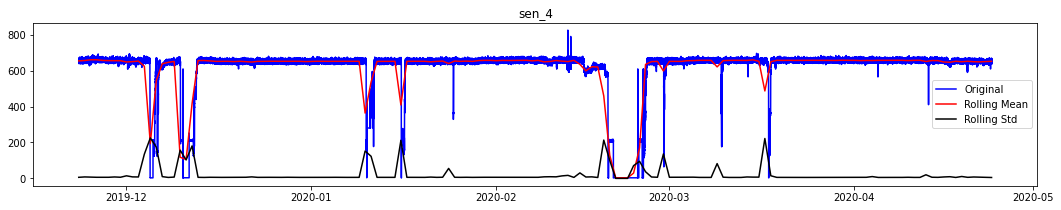

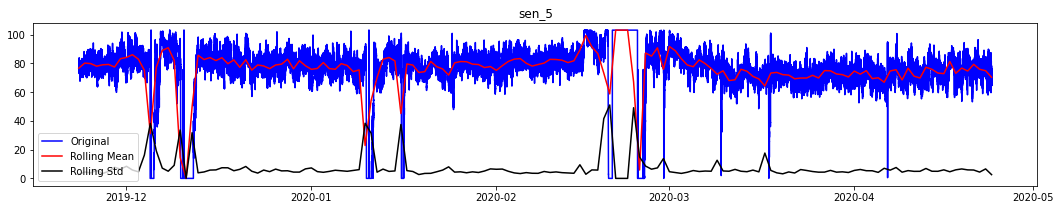

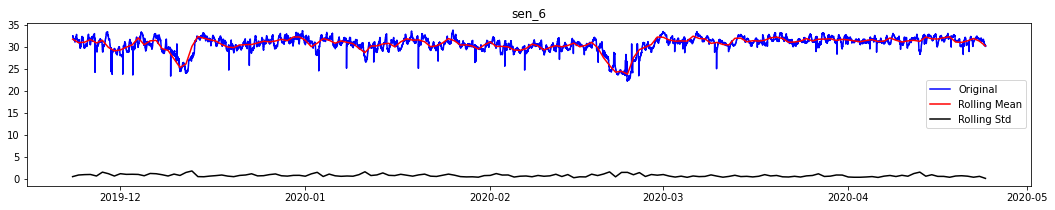

In [7]:
# Resample the entire dataset by daily average
rollmean = df.resample(rule='D').mean()
rollstd = df.resample(rule='D').std()
# Plot time series for each sensor with its mean and standard deviation
for name in names:
  plt.figure(figsize=(18,3))
  plt.plot(df[name], color='blue', label='Original')
  plt.plot(rollmean[name], color='red', label='Rolling Mean')
  plt.plot(rollstd[name], color='black', label='Rolling Std' )
  plt.legend(loc='best')
  plt.title(name)
  plt.show()

Sensors 0, 4, 5 have a larger peaks in their standard deviation indicating less stationary data. This can be confirmed with Dickey Fuller test for each sensor data. These drops/swings in the sensor values occur on days when the machine_op indicates its broken. 

### Scaling and Extracting features from the dataset

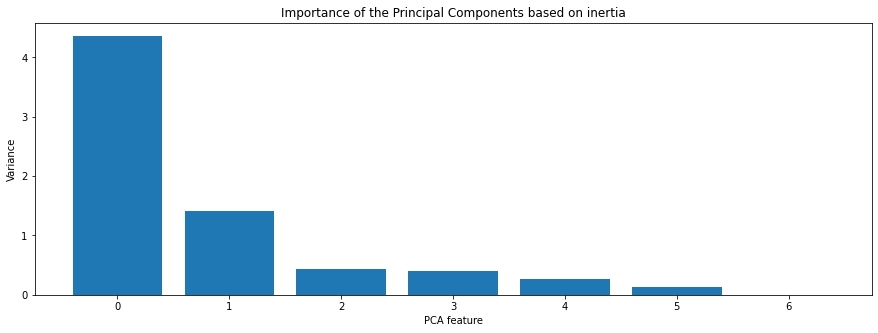

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

df2 = df.drop(['machine_op'], axis=1)
names=df2.columns
x = df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
plt.figure(figsize=(15, 5))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [9]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

### Running Dickey Fuller Test to verify stationarity of data

In [10]:
from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc1'])
print(result[1])

8.747988511117325e-09


In [11]:
result = adfuller(principalDf['pc2'])
print(result[1])

5.192810258764075e-23


### Plot Autocorrelation between these 2 features

In [12]:
# Compute change in daily mean 
pca1 = principalDf['pc1'].pct_change()
# Compute autocorrelation
autocorrelation = pca1.dropna().autocorr()
print('Autocorrelation is: ', autocorrelation)

Autocorrelation is:  -2.032124851295386e-05


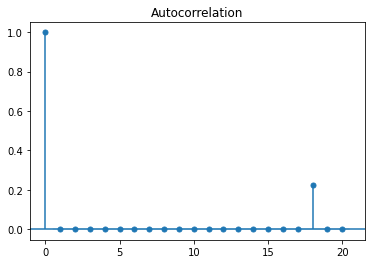

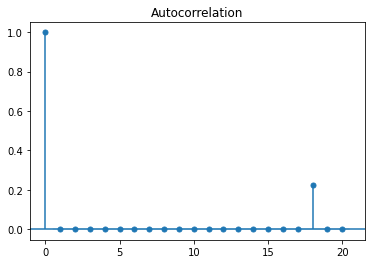

In [13]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pca1.dropna(), lags=20, alpha=0.05)

In [14]:
# Compute change in daily mean 
pca2 = principalDf['pc2'].pct_change()
# Compute autocorrelation
autocorrelation = pca2.autocorr()
print('Autocorrelation is: ', autocorrelation)

Autocorrelation is:  -2.181008404227289e-05


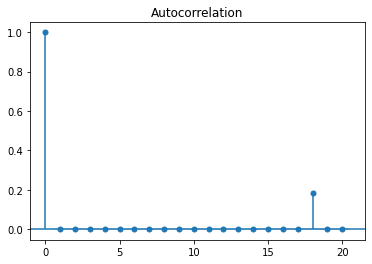

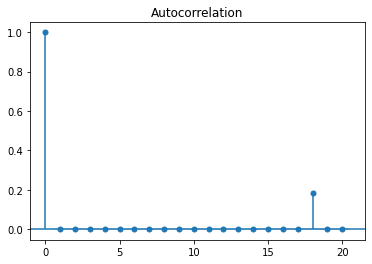

In [15]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pca2.dropna(), lags=20, alpha=0.05)

As seen from above, both features "pca1" and "pca2" are stationary and independent variables.

## Modelling Fault Detection

With the idea that anomalies, here "broken" and "recovering" phases are distinct from normal modes of operation, i am doing K-means clustering with N=2, to determine which signals fall under Normal and which under Abnormal.

In [16]:
# Import necessary libraries
from sklearn.cluster import KMeans
import numpy as np
# I will start k-means clustering with k=2 as I already know that there are 3 classes of "NORMAL" vs 
# "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

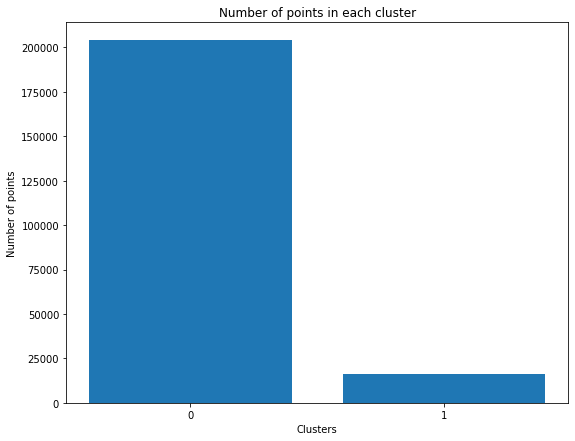

In [17]:
plt.figure(figsize = (9, 7))
plt.bar(clusters[0], clusters[1], tick_label=clusters[0])
plt.xlabel('Clusters')
plt.ylabel('Number of points')
plt.title('Number of points in each cluster')
plt.show()

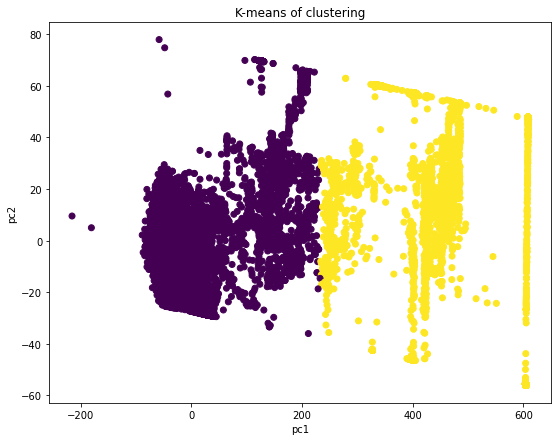

In [18]:
plt.figure(figsize=(9,7))
plt.scatter(principalDf['pc1'], principalDf['pc2'], c=labels)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-means of clustering')
plt.show()

## Visualizing in the original dataset

In [19]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [20]:
# Assume that 1% of the entire data set are anomalies 
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to 1% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 1% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

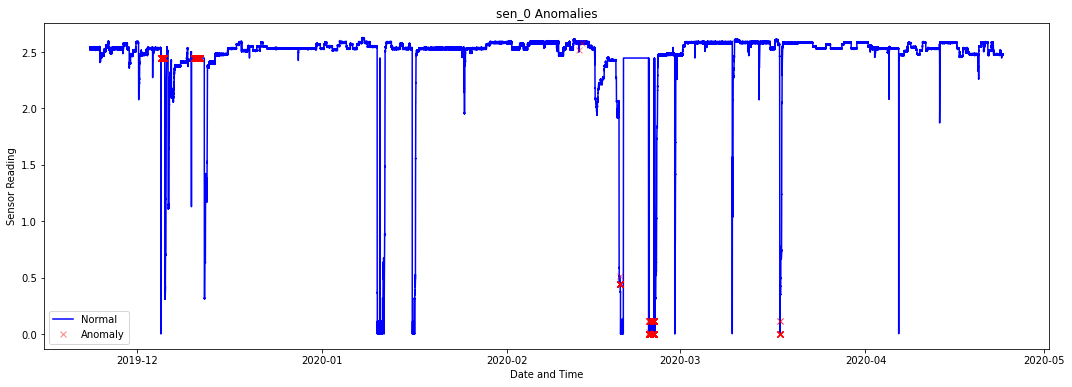

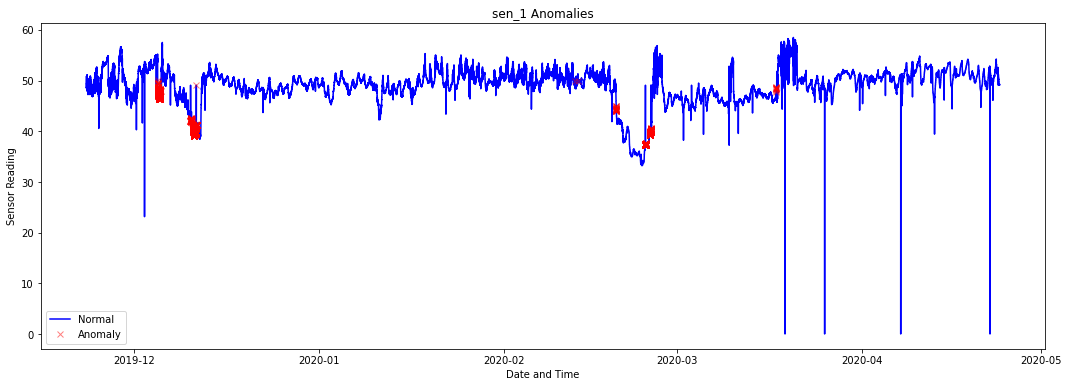

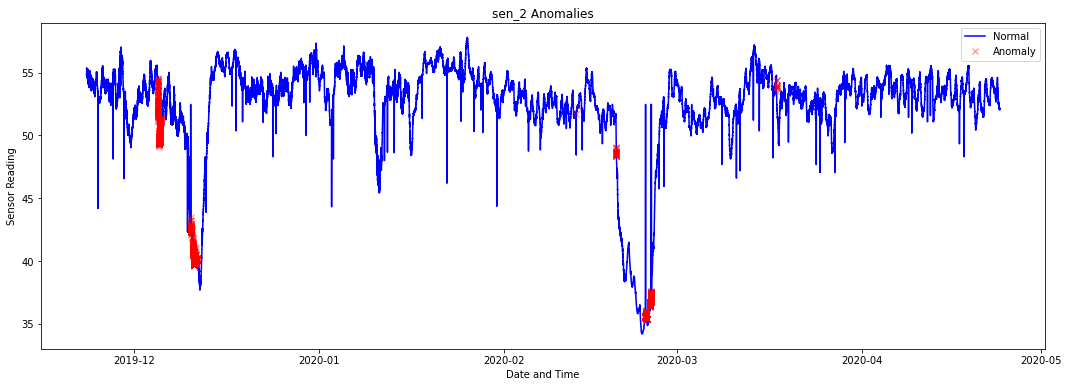

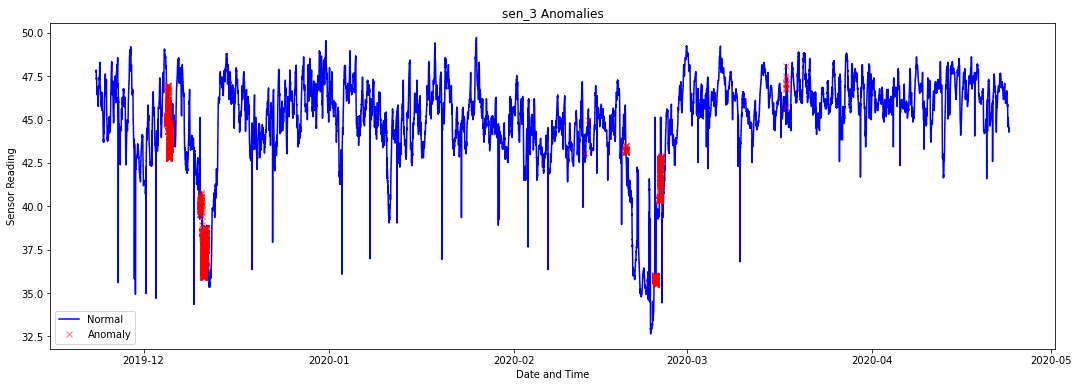

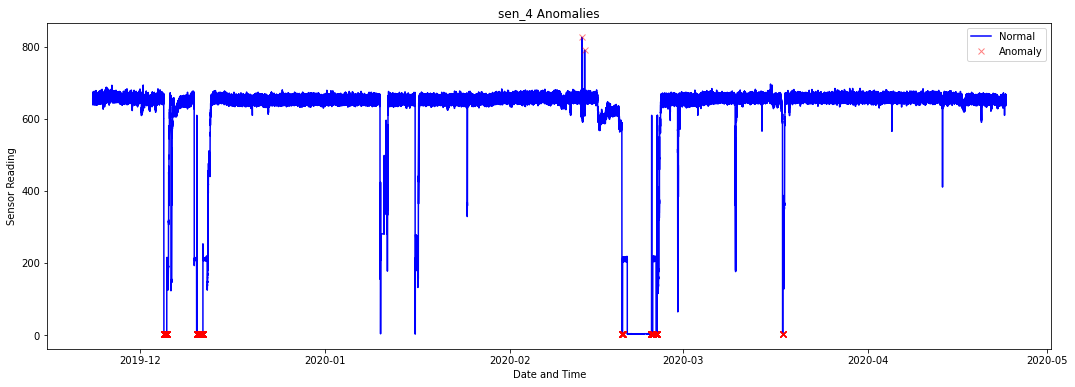

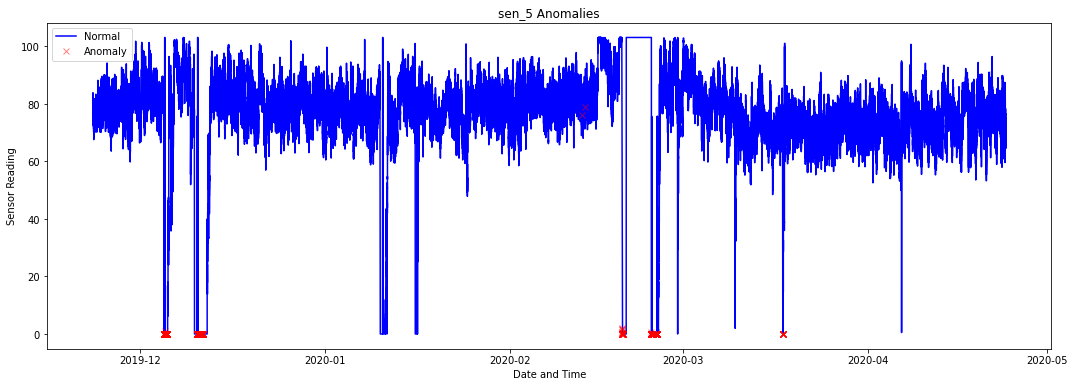

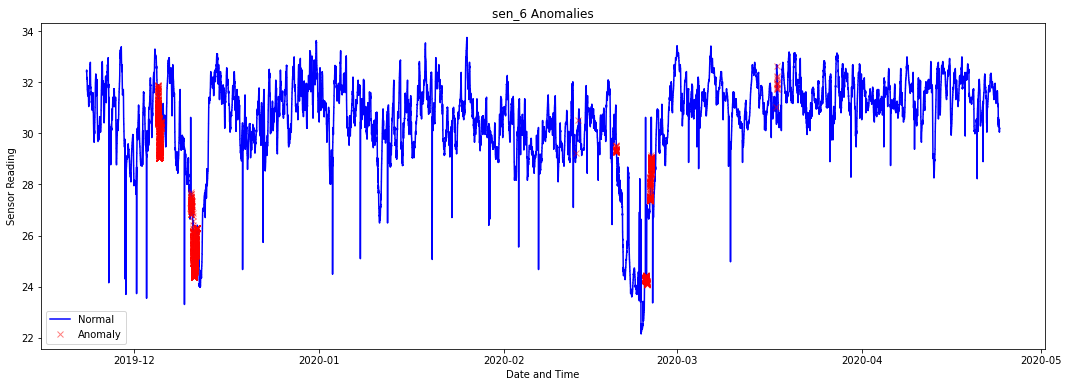

In [21]:
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
a = df[df['anomaly1'] == 1] #anomaly

for name in names:
  plt.figure(figsize=(18,6))
  plt.plot(df[name], color='blue', label='Normal')
  plt.plot(a[name], linestyle='none', marker='x', alpha=0.5, color='red', label='Anomaly')
  plt.xlabel('Date and Time')
  plt.ylabel('Sensor Reading')
  plt.title(f'{name} Anomalies')
  plt.legend(loc='best')
plt.show()